In [1]:
from ast import mod
from telnetlib import DM
from turtle import mode
from unicodedata import name
import gym
from copy import deepcopy
import os
import os.path as osp
import torch
from scipy import stats
from statistics import mean 
import numpy as np
from torch.optim import Adam
import itertools
import random
import torch.nn as nn
import argparse

In [2]:
def print_2f(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args))
def print_2f_tab(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args), sep='\t')

def get_action(o, md, deterministic=True):
    o = torch.as_tensor(o, dtype=torch.float32)
    a = md.act(o)
    return a

def get_q(o, a, md):
    o = torch.as_tensor(o, dtype=torch.float32)
    a = torch.as_tensor(a, dtype=torch.float32)
    q1 = md.q1(o, a)
    q2 = md.q2(o, a)
    return torch.min(q1, q2)

def run_extra_steps(env, o, ep_len, md, max_ep_len, step_num = 50):
    # return 0
    # print(env.done)
    total_r = 0
    for i in range(step_num):
        a = get_action(o, md)
        o, r, d, _ = env.step(a)
        total_r += r
        ep_len += 1
        if d or (ep_len == max_ep_len):
            # print(i, d, r, ep_len, max_ep_len)
            return (d, total_r)
    return (d, total_r)


def save_state(env):
    return env.sim.get_state()

def restore_state(env, old_state):
    env.reset()
    env.sim.set_state(old_state)
    env.sim.forward()
    return env.get_obs()

def vmean(v):
    return sum(v) / len(v)

def test_model(env, model, max_ep_len=None, num_episodes=20, interval = 1):
    o, r, d, ep_ret, ep_len, n = env.reset(), 0, False, 0, 0, 0
    total_rewards = []
    trajs = []
    mid_points = {}
    while n < num_episodes:
        if ep_len % interval == 0:
            old_state = save_state(env)
            mid_points[ep_len] = old_state
        a = get_action(o, model)
        o, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1
        if d or (ep_len == max_ep_len):
            total_rewards.append(ep_ret)
            trajs.append(mid_points)
            mid_points = {}
            o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
            n += 1
    return total_rewards, trajs

def get_good_trajs(env, model, num, max_ep_len=1000):
    total_rewards = []
    trajs = []
    old_r = []
    while len(total_rewards) < num:
        r, t = test_model(env, model, max_ep_len, num - len(total_rewards))
        old_r = old_r + r
        thr = vmean(old_r)
        for i in range(len(r)):
            if thr <= r[i] and len(t[i])>=500:
                total_rewards.append(r[i])
                trajs.append(t[i])
    return total_rewards, trajs
def get_all_models(path, env_name, name):
    env = gym.make(env_name)
    fpath = osp.join(path, name)
    models = []
    file_names = os.listdir(fpath)
    if len(file_names) == 0:
        return []
    if 'ppo' in name:
        for file_name in file_names:
            if '.pt' in file_name:
                fname = osp.join(fpath, file_name)
                print(fname)
                env = gym.make(env_name)
                obs_dim = env.observation_space.shape[0]
                action_dim = env.action_space.shape[0]
                model = PPO_Actor(obs_dim, action_dim, (64, 64), nn.Tanh)
                model.load(fname)
                models.append(model)
    else:
        for file_name in file_names:   
            fname = osp.join(fpath, file_name ,'pyt_save', 'model.pt')
            print(fname)
            model = torch.load(fname)
            models.append(model)
    return models

In [3]:
def test_continue_problem(path, env_name, name, traj_num=10, extra_step=50):
    models = get_all_models(path, env_name, name)
    # good_trajs = []
    traj_rs = []
    env = gym.make(env_name)
    step_nums = [400, 411, 434, 471, 489]
    dr = []
    for i in range(len(models)):
        dr.append([])
        model = models[i]
        rs, gts = get_good_trajs(env, model, traj_num)
        print(vmean(rs))
        traj_rs.append(vmean(rs))
        for j in range(len(models)):
            m =  models[j]
            dr[i].append([])
            for t in gts:
                for step_num in step_nums:
                    old_state = t[step_num-1]
                    o = restore_state(env, old_state)
                    o_copy = deepcopy(o)
                    dd, rr = run_extra_steps(env, o, step_num, m, 1000, extra_step)
                    if rr < extra_step:
                        dd = True
                    ai = get_action(o, model)
                    aj = get_action(o, m)
                    qii = get_q(o_copy, ai, model)
                    qij = get_q(o_copy, ai, m)
                    qji = get_q(o_copy, aj, model)
                    qjj = get_q(o_copy, aj, m)
                    dr[i][j].append((dd, rr, qii, qij, qji, qjj))
    return dr
path = '/home/lclan/spinningup/data/'
dr = test_continue_problem(path, 'Walker2d-v3', 'Walker2d-v3_sac_base_train')

/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1027/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1039/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1038/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1025/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1029/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1035/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1024/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1028/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1033/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_ba

/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
print(dr[0][1][0])

(False, 244.935667851729, tensor(543.2841, grad_fn=<MinBackward2>), tensor(474.7729, grad_fn=<MinBackward2>), tensor(541.2099, grad_fn=<MinBackward2>), tensor(475.2404, grad_fn=<MinBackward2>))


In [14]:
bl = []
gl = []
sr = []

for i in range(len(dr)):
    for j in range(len(dr[i])):
        if i == j:
            for k in range(len(dr[i][j])):
                data = dr[i][j][k]
                new_data = (data[1], data[2].detach().numpy())
                sr.append(new_data)
        else:
            for k in range(len(dr[i][j])):
                data = dr[i][j][k]
                new_data = (data[1], data[2].detach().numpy(), data[3].detach().numpy(), data[4].detach().numpy(),data[5].detach().numpy())
                if data[0]: # dd
                    bl.append(new_data)
                else:
                    gl.append(new_data)


            

In [23]:
print(len(bl))
print(len(gl))


991
11009


In [25]:
print(vmean([x[0] for x in bl]))
print(vmean([x[0] for x in gl]))
print(vmean([x[0] for x in sr]))

206.96069867325212
278.6892011182355
290.4217206064811


In [26]:
# q11
def print_q(l):
    r  = vmean([x[0] for x in l])
    qii = vmean([x[1] for x in l])
    qij = vmean([x[2] for x in l])
    qji = vmean([x[3] for x in l])
    qjj = vmean([x[4] for x in l])
    print(r/0.60, qii, qij, qji, qjj)

print_q(bl)
print_q(gl)


344.93449778875356 531.9447401491352 254.94896769210862 527.9247554775203 269.8382647155392
464.4820018637258 540.563596429027 420.722683522452 537.628123795264 429.4876857716507


In [29]:
dr2 = test_continue_problem(path, 'Walker2d-v3', 'Walker2d-v3_sac_base_train', traj_num=25, extra_step=500)

/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1027/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1039/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1038/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1025/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1029/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1035/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1024/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1028/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_base_train/Walker2d-v3_sac_base_train_s1033/pyt_save/model.pt
/home/lclan/spinningup/data/Walker2d-v3_sac_ba

In [35]:
def get_ls(dr):
    bl = []
    gl = []
    sr = []
    for i in range(len(dr)):
        for j in range(len(dr[i])):
            if i == j:
                for k in range(len(dr[i][j])):
                    data = dr[i][j][k]
                    new_data = (data[1], data[2].detach().numpy())
                    sr.append(new_data)
            else:
                for k in range(len(dr[i][j])):
                    data = dr[i][j][k]
                    new_data = (data[1], data[2].detach().numpy(), data[3].detach().numpy(), data[4].detach().numpy(),data[5].detach().numpy())
                    if data[0]: # dd
                        bl.append(new_data)
                    else:
                        gl.append(new_data)
    return bl, gl, sr

def print_q(l):
    r  = vmean([x[0] for x in l])
    qii = vmean([x[1] for x in l])
    qij = vmean([x[2] for x in l])
    qji = vmean([x[3] for x in l])
    qjj = vmean([x[4] for x in l])
    print(r/5, qii, qij, qji, qjj)
    

bl2, gl2, sr2 = get_ls(dr2)
print(vmean([x[0] for x in bl2]), vmean([x[0] for x in gl2]), vmean([x[0] for x in sr2]))
print_q(bl2)
print_q(gl2)
print(vmean([x[0] for x in sr2])/5, vmean([x[1] for x in sr2]))

413.8019294121779 2812.457616390589 2916.3987976251274
82.76038588243559 536.9886038385087 309.2519179372655 532.9022700915225 321.14817003011296
562.4915232781178 540.810352622627 430.3992054421882 538.0670599827062 438.85772712666056
583.2797595250255 540.0595063781739


In [36]:
drhu = test_continue_problem(path, 'Humanoid-v3', 'Humanoid-v3_sac_base_train', traj_num=25, extra_step=500)

/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1034/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1033/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1027/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1025/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1026/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1038/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1035/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1028/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_base_train/Humanoid-v3_sac_base_train_s1024/pyt_save/model.pt
/home/lclan/spinningup/data/Humanoid-v3_sac_ba

In [37]:
blhu, glhu, srhu = get_ls(drhu)
print(vmean([x[0] for x in blhu]), vmean([x[0] for x in glhu]), vmean([x[0] for x in srhu]))
print_q(blhu)
print_q(glhu)
print(vmean([x[0] for x in srhu])/5, vmean([x[1] for x in srhu]))

468.7371753655101 2703.787088179632 2670.918894147001
93.74743507310203 582.1391768640017 137.34757094063087 578.7608656608966 155.920021008009
540.7574176359265 586.8838165634846 299.21471700072 584.5455050471711 326.4585476590062
534.1837788294002 585.3715417366028


In [43]:
def get_distribution(dr):
    model_num = len(dr)
    points_count = len(dr[0][0])
    print(model_num, points_count)
    ret = [0] * model_num
    sum = 0
    fall = 0
    for i in range(model_num):
        for k in range(points_count):
            if dr[i][i][k][0]: # hard for old 
                fall +=1
                continue
            cnt = 0
            for j in range(model_num):
                if i != j:
                    if dr[i][j][k][0]:
                        cnt += 1
            ret[cnt] += 1
            sum+=1
    
    ret = [x/sum*100 for x in ret]
    print("fail num: ", fall)
    print_2f(*ret)
    acc = [ret[0]]
    for i in range(1, model_num):
        tmp = acc[i-1] + ret[i]
        acc.append(tmp)
    print_2f(*acc)
    return ret

get_distribution(dr2)
get_distribution(drhu)

16 125
fail num:  0
12.70 26.75 18.25 11.35 6.55 5.10 5.10 5.95 3.50 2.55 1.75 0.40 0.05 0.00 0.00 0.00
12.70 39.45 57.70 69.05 75.60 80.70 85.80 91.75 95.25 97.80 99.55 99.95 100.00 100.00 100.00 100.00
16 125
fail num:  69
2.33 6.73 11.39 15.07 15.43 13.88 10.77 8.29 6.01 4.19 2.69 1.81 1.04 0.36 0.00 0.00
2.33 9.06 20.46 35.53 50.96 64.84 75.61 83.89 89.90 94.10 96.79 98.60 99.64 100.00 100.00 100.00


[2.330398757120663,
 6.732263076126359,
 11.393060590367684,
 15.06991196271362,
 15.432418436043502,
 13.878819264629724,
 10.771620921802175,
 8.285862247540136,
 6.007250129466598,
 4.194717762817193,
 2.6929052304505436,
 1.8125323666494046,
 1.035732780942517,
 0.3625064733298809,
 0.0,
 0.0]

16 125
fail num and rate:  0 0.19646666666666668
0.13 0.27 0.18 0.11 0.07 0.05 0.05 0.06 0.04 0.03 0.02 0.00 0.00 0.00 0.00 0.00
0.04 0.14 0.24 0.25 0.18 0.10 0.04 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00


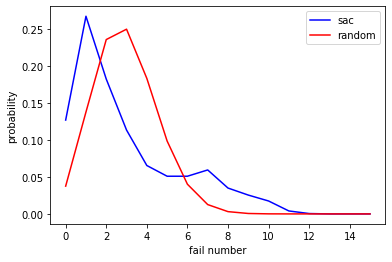

In [52]:
import matplotlib.pyplot as plt
from scipy.stats import binom
def print_distribution(dr):
    model_num = len(dr)
    points_count = len(dr[0][0])
    print(model_num, points_count)
    ret = [0] * model_num
    sum = 0
    fall = 0
    data_num = 0
    data_d_num = 0
    for i in range(model_num):
        for k in range(points_count):
            if dr[i][i][k][0]: # hard for old 
                fall +=1
                continue
            
            cnt = 0
            for j in range(model_num):
                if i != j:
                    data_num += 1
                    if dr[i][j][k][0]:
                        cnt += 1
                        data_d_num += 1
            ret[cnt] += 1
            sum+=1
    
    ret = [x/sum for x in ret]
    print("fail num and rate: ", fall, data_d_num / data_num)
    print_2f(*ret)
    colors = ['blue', 'red']
    x = range(0, model_num)
    rv = binom(model_num-1, data_d_num / data_num)
    rand_dis = rv.pmf(x)
    names = ['sac', 'random']
    print_2f(*rand_dis)
    plt.plot(x, ret, color='blue', label='sac')
    plt.plot(x, rand_dis, color='red', label='random')
    plt.legend()
    plt.xlabel('fail number')
    plt.ylabel('probability')

print_distribution(dr2)

    

16 125
fail num and rate:  69 0.3188675988261695
0.02 0.07 0.11 0.15 0.15 0.14 0.11 0.08 0.06 0.04 0.03 0.02 0.01 0.00 0.00 0.00
0.00 0.02 0.07 0.15 0.21 0.21 0.17 0.10 0.05 0.02 0.00 0.00 0.00 0.00 0.00 0.00


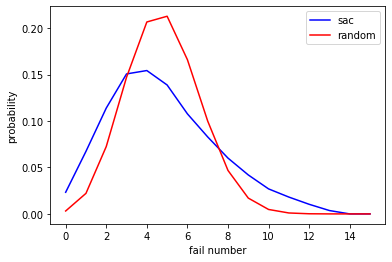

In [53]:
print_distribution(drhu)

In [10]:
import random
l = list(range(3))
random.shuffle(l)
print(l)

[0, 1, 2]
